In [10]:
"""
Visualizing Feature Importance Rankings (Tree-based models)

We will:
1) Create a business-style dataset (Customer Churn)
2) Train tree-based models: Decision Tree, Random Forest, Gradient Boosting
3) Calculate feature importance (model.feature_importances_)
4) Visualize:
   - Bar chart (top features)
   - Ranked list (ordered importance)
   - Heatmap (compare importance across models)

Requirements:
pip install scikit-learn pandas matplotlib
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier





In [12]:
# -----------------------------
# 1) Create a simple "Customer Churn" dataset (synthetic but realistic)
# -----------------------------
rng = np.random.default_rng(42)
n = 1200

df = pd.DataFrame({
    # numeric
    "tenure_months": rng.integers(1, 72, size=n),
    "monthly_charges": rng.normal(65, 18, size=n).clip(10, 150),
    "support_tickets_30d": rng.poisson(1.2, size=n).clip(0, 10),
    "avg_weekly_app_minutes": rng.normal(75, 30, size=n).clip(0, 300),
    "late_payments_6m": rng.poisson(0.6, size=n).clip(0, 8),

    # categorical
    "contract_type": rng.choice(["Month-to-month", "One year", "Two year"], size=n, p=[0.55, 0.25, 0.20]),
    "payment_method": rng.choice(["Card", "UPI", "NetBanking", "Cash"], size=n, p=[0.35, 0.35, 0.20, 0.10]),
    "internet_service": rng.choice(["Fiber", "DSL", "None"], size=n, p=[0.55, 0.35, 0.10]),
})

# Create churn probability (ground-truth signal) — higher churn for:
# - short tenure, high charges, more tickets, month-to-month contracts, more late payments, low app usage
logit = (
    -0.04 * df["tenure_months"]
    + 0.018 * df["monthly_charges"]
    + 0.35 * df["support_tickets_30d"]
    + 0.22 * df["late_payments_6m"]
    - 0.006 * df["avg_weekly_app_minutes"]
)

logit += (df["contract_type"] == "Month-to-month") * 0.9
logit += (df["internet_service"] == "Fiber") * 0.25
logit += (df["payment_method"] == "Cash") * 0.35

prob = 1 / (1 + np.exp(-logit))
df["churn"] = rng.binomial(1, prob)



In [13]:
# -----------------------------
# 2) Train-test split
# -----------------------------
X = df.drop(columns=["churn"])
y = df["churn"]

numeric_features = [
    "tenure_months", "monthly_charges", "support_tickets_30d",
    "avg_weekly_app_minutes", "late_payments_6m"
]
categorical_features = ["contract_type", "payment_method", "internet_service"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)



In [14]:
# -----------------------------
# 3) Preprocessing: One-hot encode categorical features
# -----------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop"
)

# Helper to get feature names after preprocessing
def get_feature_names(preprocessor: ColumnTransformer) -> list[str]:
    # Numeric names
    num_names = numeric_features

    # OneHot names
    ohe: OneHotEncoder = preprocessor.named_transformers_["cat"]
    cat_names = ohe.get_feature_names_out(categorical_features).tolist()

    return num_names + cat_names




In [15]:
# -----------------------------
# 4) Define models (tree-based)
# -----------------------------
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

# Train pipelines and collect importances
importances = {}
aucs = {}
feature_names = None

for name, model in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", model)])
    pipe.fit(X_train, y_train)

    # Evaluate quickly (AUC)
    proba = pipe.predict_proba(X_test)[:, 1]
    aucs[name] = roc_auc_score(y_test, proba)

    # Get transformed feature names once (after fit)
    if feature_names is None:
        fitted_pre = pipe.named_steps["prep"]
        feature_names = get_feature_names(fitted_pre)

    # Extract tree-based feature importances
    fi = pipe.named_steps["clf"].feature_importances_
    importances[name] = fi

# Convert to DataFrame for easy ranking/plotting
fi_df = pd.DataFrame(importances, index=feature_names)

print("Model AUC (higher is better):")
for k, v in aucs.items():
    print(f"  {k:16s}: {v:.3f}")



Model AUC (higher is better):
  Decision Tree   : 0.718
  Random Forest   : 0.750
  Gradient Boosting: 0.738


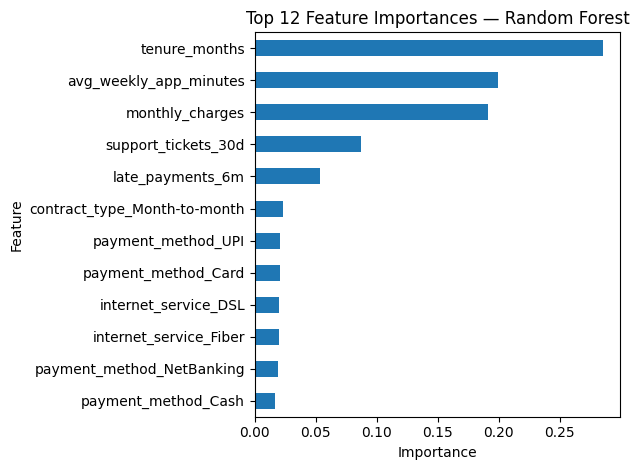

In [16]:
# -----------------------------
# 5) Visualization A — Bar chart (Top N features for one model)
# -----------------------------
model_to_plot = "Random Forest"
top_n = 12

ranked = fi_df[model_to_plot].sort_values(ascending=False).head(top_n)

plt.figure()
ranked.sort_values().plot(kind="barh")  # horizontal bar chart
plt.title(f"Top {top_n} Feature Importances — {model_to_plot}")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



In [17]:
# -----------------------------
# 6) Visualization B — Ranked list (Ordered importance)
# -----------------------------
print(f"\nRanked Feature List (Top {top_n}) — {model_to_plot}")
for i, (feat, score) in enumerate(ranked.items(), start=1):
    print(f"{i:2d}. {feat:35s}  {score:.4f}")




Ranked Feature List (Top 12) — Random Forest
 1. tenure_months                        0.2853
 2. avg_weekly_app_minutes               0.1997
 3. monthly_charges                      0.1915
 4. support_tickets_30d                  0.0874
 5. late_payments_6m                     0.0539
 6. contract_type_Month-to-month         0.0231
 7. payment_method_UPI                   0.0204
 8. payment_method_Card                  0.0204
 9. internet_service_DSL                 0.0199
10. internet_service_Fiber               0.0196
11. payment_method_NetBanking            0.0187
12. payment_method_Cash                  0.0165


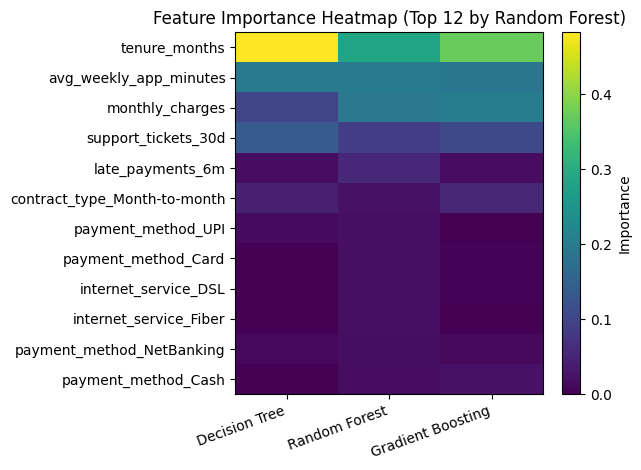

In [18]:
# -----------------------------
# 7) Visualization C — Heatmap (Compare across models)
#    We'll use the SAME top features (from one reference model) for a fair comparison
# -----------------------------
top_features_for_heatmap = fi_df[model_to_plot].sort_values(ascending=False).head(top_n).index
heat = fi_df.loc[top_features_for_heatmap, list(models.keys())]

plt.figure()
plt.imshow(heat.values, aspect="auto")  # default colormap
plt.title(f"Feature Importance Heatmap (Top {top_n} by {model_to_plot})")
plt.yticks(range(top_n), heat.index)
plt.xticks(range(len(heat.columns)), heat.columns, rotation=20, ha="right")
plt.colorbar(label="Importance")
plt.tight_layout()
plt.show()



In [19]:
# -----------------------------
# 8) Identify "stable" features across models
# -----------------------------
heat["avg_importance"] = heat.mean(axis=1)
stable = heat["avg_importance"].sort_values(ascending=False)

print("\nMost consistently important features (avg across models):")
print(stable.head(10).to_string())


Most consistently important features (avg across models):
tenure_months                   0.379720
avg_weekly_app_minutes          0.195167
monthly_charges                 0.165177
support_tickets_30d             0.111132
contract_type_Month-to-month    0.039431
late_payments_6m                0.028343
payment_method_NetBanking       0.013682
payment_method_Cash             0.013172
payment_method_UPI              0.011964
payment_method_Card             0.008293
